1. Setup and Install Dependencies

In [1]:
!pip install -q librosa torchaudio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.7 MB/s eta 0:00:00


2. Import Required Libraries

In [2]:
import os
import numpy as np
import torch
import torchaudio
import librosa
import librosa.display
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder


3. Download and Extract TESS Dataset

In [3]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wajeekhan","key":"ab5d59488a7c0b81b435b3f383423929"}'}

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Secure it


In [5]:
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess -p tess_data --unzip


Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 97% 413M/428M [00:02<00:00, 161MB/s]
100% 428M/428M [00:02<00:00, 154MB/s]


In [6]:
!ls tess_data


'tess toronto emotional speech set data'  'TESS Toronto emotional speech set data'


In [7]:
import os
data_path = "tess_data/TESS-Toronto-emotional-speech-set-data"
audio_files = [f for root, _, files in os.walk(data_path) for f in files if f.endswith(".wav")]
print(f"Total samples: {len(audio_files)}")


Total samples: 0


4. Load Dataset Paths and Labels

In [21]:
import os
from sklearn.preprocessing import LabelEncoder

# Define emotion mapping to 7 basic emotions
EMOTION_MAP = {
    'YAF_neutral': 'neutral', 'OAF_neutral': 'neutral',
    'YAF_sad': 'sad', 'OAF_Sad': 'sad',
    'YAF_pleasant_surprised': 'pleasant_surprised', 'OAF_Pleasant_surprise': 'pleasant_surprised',
    'YAF_happy': 'happy', 'OAF_happy': 'happy',
    'YAF_fear': 'fear', 'OAF_Fear': 'fear',
    'YAF_angry': 'angry', 'OAF_angry': 'angry',
    'YAF_disgust': 'disgust', 'OAF_disgust': 'disgust'
}

# Extract file paths and mapped labels
data_dir = "/content/tess_data/TESS Toronto emotional speech set data"
file_paths, labels = [], []

for folder_name, emotion in EMOTION_MAP.items():
    emotion_dir = os.path.join(data_dir, folder_name)
    if os.path.exists(emotion_dir):
        for file in os.listdir(emotion_dir):
            if file.endswith(".wav"):
                file_paths.append(os.path.join(emotion_dir, file))
                labels.append(emotion)  # Assign mapped emotion

# Encode labels to integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)




In [22]:
print(f"Total samples: {len(file_paths)}")
print(f"Unique Labels after mapping: {list(label_encoder.classes_)}")

Total samples: 2800
Unique Labels after mapping: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'pleasant_surprised', 'sad']


5. Audio Feature Extraction (MFCCs)

In [23]:
def extract_features(file_path, max_pad_length=128):
    y, sr = librosa.load(file_path, sr=16000)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

    # Padding to ensure fixed size
    pad_width = max(0, max_pad_length - mfccs.shape[1])
    mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')

    return mfccs


6. Create PyTorch Dataset

In [24]:
class EmotionDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        features = extract_features(self.file_paths[idx])
        label = self.labels[idx]

        # Convert to tensor
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Create dataset instance
dataset = EmotionDataset(file_paths, labels)


In [25]:
print(f"Total Samples: {len(dataset)}")


Total Samples: 2800


In [28]:
# Split into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [29]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

7. Define CNN Model for Emotion Detection

In [41]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=40, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(4096, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


8. Model Training Function

In [42]:
def train_model(model, train_loader, criterion, optimizer, device, epochs=10):
    model.to(device)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")


9. Model Evaluation Function

In [43]:
def evaluate_model(model, test_loader, device):
    model.to(device)
    model.eval()

    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {correct / total * 100:.2f}%")


10. Train and Evaluate the Model

In [44]:
# Test model
model = EmotionCNN()
print(model)

EmotionCNN(
  (conv1): Conv1d(40, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
)


In [45]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss function, and optimizer
model = EmotionCNN(num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, train_loader, criterion, optimizer, device, epochs=10)

# Evaluate the model
evaluate_model(model, test_loader, device)


Epoch [1/10], Loss: 0.6820
Epoch [2/10], Loss: 0.0120
Epoch [3/10], Loss: 0.0028
Epoch [4/10], Loss: 0.0003
Epoch [5/10], Loss: 0.0001
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Test Accuracy: 100.00%


Confusion Matrix

<Figure size 800x600 with 0 Axes>

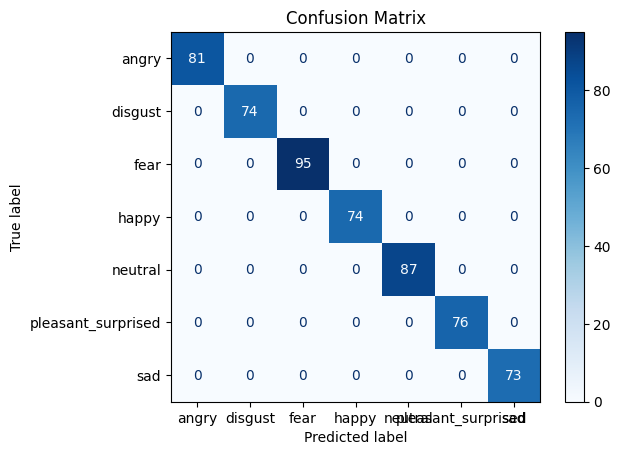

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions for test set
y_true, y_pred = [], []
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


11. Test on a New Audio Sample

In [50]:
def predict_emotion(model, file_path, device):
    model.to(device)
    model.eval()

    features = extract_features(file_path)
    features = torch.tensor(features, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(features)
        predicted_label = torch.argmax(output, dim=1).item()

    emotion = label_encoder.inverse_transform([predicted_label])[0]
    print(f"Predicted Emotion: {emotion}")



In [52]:
# Example usage:
predict_emotion(model, "/content/OAF_came_ps.wav", device)

Predicted Emotion: pleasant_surprised
